In [ ]:
!nvidia-smi

In [ ]:
!pip install monai==1.2.0 gdown

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import monai
import torch
import time

### Data list
Upload the spleen samples and copy them into `mydata` folder </br>
Link: https://drive.google.com/file/d/1lE6cwNhtFPd0KkkaCDdNNeGWinLmxA-R/view?usp=sharing </br>
(source: http://medicaldecathlon.com/) </br>
Or using gdown:

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1lE6cwNhtFPd0KkkaCDdNNeGWinLmxA-R/view?usp=sharing

In [ ]:
!unzip spleen_samples.zip
!mv data/ mydata
!ls

In [ ]:
keys = ['img', 'seg']
data_dir = './mydata/'
fns = os.listdir(data_dir+'spleen_img/')
fpaths = [{key: data_dir+'spleen_'+key+'/'+fn for key in keys} for fn in fns]

In [ ]:
fpaths

### Preview

In [ ]:
sample = monai.transforms.LoadImaged(keys)(fpaths[0])
sample['img'].shape

In [ ]:
from IPython.display import clear_output

vmax = sample['img'].max()
vmin = sample['img'].min()
for i in range(sample['img'].shape[-1]):
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.imshow(sample['img'][..., i], cmap='gray', vmax=vmax, vmin=vmin)
    plt.title(str(i+1)+'/'+str(sample['img'].shape[-1]))
    plt.subplot(122)
    plt.imshow(sample['seg'][..., i], cmap='gray')
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

### Transforms
Fix the transforms below. Ref: https://docs.monai.io/en/stable/transforms.html

In [ ]:
spatial_size = [128, 128, 16]
prob = 0.5
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys), 
                                  monai.transforms.AddChanneld(keys), 
                                  monai.transforms.EnsureTyped(keys),
                                  monai.transforms.NormalizeIntensityd('FIX ME'),
                                  monai.transforms.Resized(keys, spatial_size=spatial_size, mode=['area', 'nearest']),
                                  monai.transforms.RandScaleIntensityd(keys, 0.2, prob=prob),
                                  monai.transforms.RandFlipd('FIX ME'),
                                  monai.transforms.ToDeviced(keys, device='cuda:0')])

In [ ]:
data = trans(fpaths[0])
data['img'].shape, data['seg'].shape

### Dataset and DataLoader
Fix the dataset below. Ref: https://docs.monai.io/en/stable/data.html#cachedataset

In [ ]:
ds = monai.data.CacheDataset('FIX ME')

In [ ]:
for data in ds: print(data['img'].shape, data['seg'].shape)

In [ ]:
batch_size = 2
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size)
for data in dl: print(data['img'].shape, data['seg'].shape)

### Network, loss and optimizer
Fix the network setting. Ref: https://docs.monai.io/en/stable/networks.html#unet

In [ ]:
device = torch.device("cuda:0")

net = monai.networks.nets.UNet(
    'FIX ME'
).to(device)

net(data['img']).shape

In [ ]:
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(net.parameters(), 5e-4)

### Training

In [ ]:
max_epochs = 200
epoch_loss_values = []

# Set to training mode
net.train()
t1 = time.time()
for epoch in range(max_epochs):
    print('Epoch: '+str(epoch+1)+'/'+str(max_epochs))
    epoch_loss = 0
    for step, batch_data in enumerate(dl):
        inputs, labels = (
            batch_data["img"],
            batch_data["seg"]
        )
        # Reset optimizer 
        optimizer.zero_grad()
        # Forward
        outputs = net(inputs)
        # Loss
        loss = loss_function(outputs, labels)
        # Backward
        loss.backward()
        # Update weights
        optimizer.step()
        epoch_loss += loss.item()
        print('  Step '+str(step+1)+'/'+str(len(dl))+f', train_loss: {loss.item():.4f}')
    epoch_loss /= (step+1)
    epoch_loss_values.append(epoch_loss)
t2 = time.time()

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(epoch_loss_values, ls='--', c='r')
print('Timespan:', round(t2-t1, 4), 'seconds')

### The result should be as below:
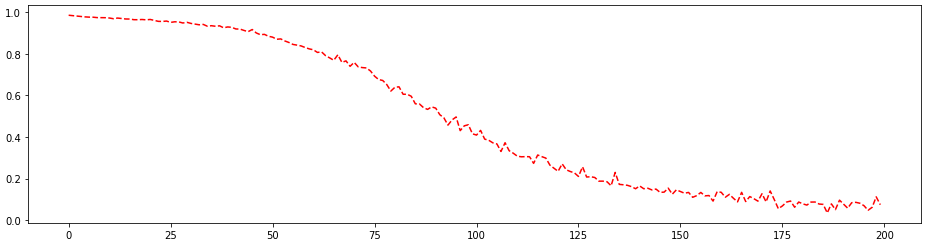

### How to accelerate the training procedure?